In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import local_maxima, erosion, dilation, opening, closing, disk
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt as distance
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
def minmax(image):
    return (image - image.min()) / (image.max() - image.min())
image = tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2.tif')
_, crypts, dapi = minmax(image[:,:,0]), minmax(image[:,:,1]), minmax(image[:,:,2])

In [7]:
def caps(image, small_r, big_r):
    selem_small, selem_large = disk(small_r), disk(big_r)    
    hats = dilation(image, footprint=selem_large) - dilation(image, footprint=selem_small)
    clean = image - np.minimum(image, hats) 
    troughs = np.maximum(image, hats) - image
    return hats, clean, troughs
#cell_hats = caps(b_eq, 2, 20)

def show_caps(image, small_r, big_r):

    hats, clean, troughs = caps(image, small_r, big_r)

    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].axis('off'); ax[1].axis('off'); ax[2].axis('off'); ax[3].axis('off');
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(hats, cmap='gray')
    ax[2].imshow(clean, cmap='gray')
    ax[3].imshow(troughs, cmap='gray')
    fig.colorbar(ax[1].imshow(hats, cmap='gray'), ax=ax[1])
    fig.colorbar(ax[2].imshow(clean, cmap='gray'), ax=ax[2])
    fig.colorbar(ax[3].imshow(troughs, cmap='gray'), ax=ax[3])
    fig.show()
    return hats, clean, troughs

# rectified_diff
Short name: pixel-wise positive difference (a.k.a. rectified difference).

- Math: 
    - thinned_crypts = max(crypt_clean - tissue_clean, 0) → the positive part (a-b)_+.
Same for split_crypts with tissue_troughs.

- In morphology terms: 
    - this is the grayscale set difference (fuzzy set difference), analogous to binary A \ B, but with intensities.

- In pipeline-speak:
    - a competitive mask / gating step—keep signal where the crypt channel dominates the tissue channel; zero elsewhere.


In [ ]:
def min_dif(image, diff)

In [16]:


tissue_hats, tissue_clean, tissue_troughs = caps(
    equalize_adapthist(dapi), 
    1, 
    20)
crypt_hats, crypt_clean, crypt_troughs = caps(crypts, 2, 20)

thinned_crypts = np.maximum( crypt_clean - tissue_clean, 0)#crypt_clean - np.minimum(crypt_clean, tissue_clean)
split_crypts = np.maximum(crypt_clean - tissue_troughs, 0)

good_crypts = minmax(
    opening(
        split_crypts * thinned_crypts,
        footprint = disk(radius=5)
        )**(1/2)
    )
distance = tissue_troughs - good_crypts
maxi = local_maxima(good_crypts)
segmented_crypts = label(
    watershed(
        distance,
        markers = maxi,
        mask = tissue_troughs<good_crypts
    )
)

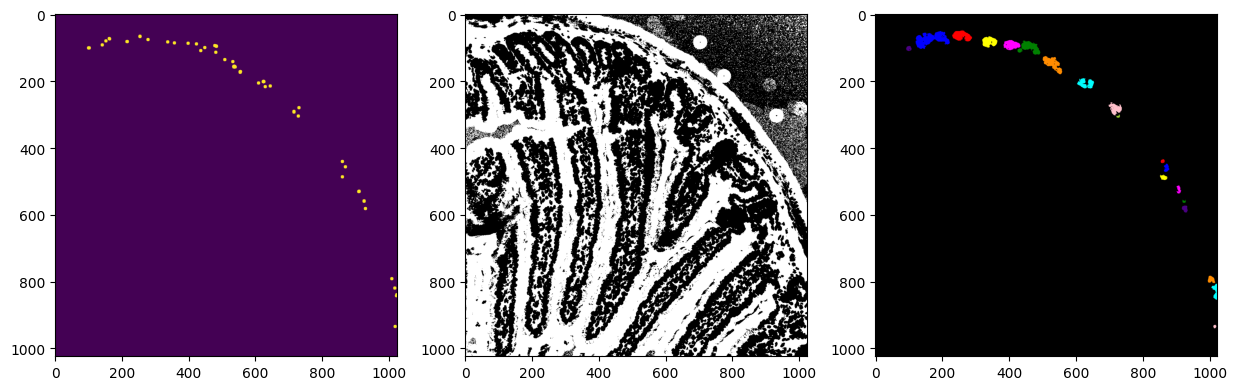

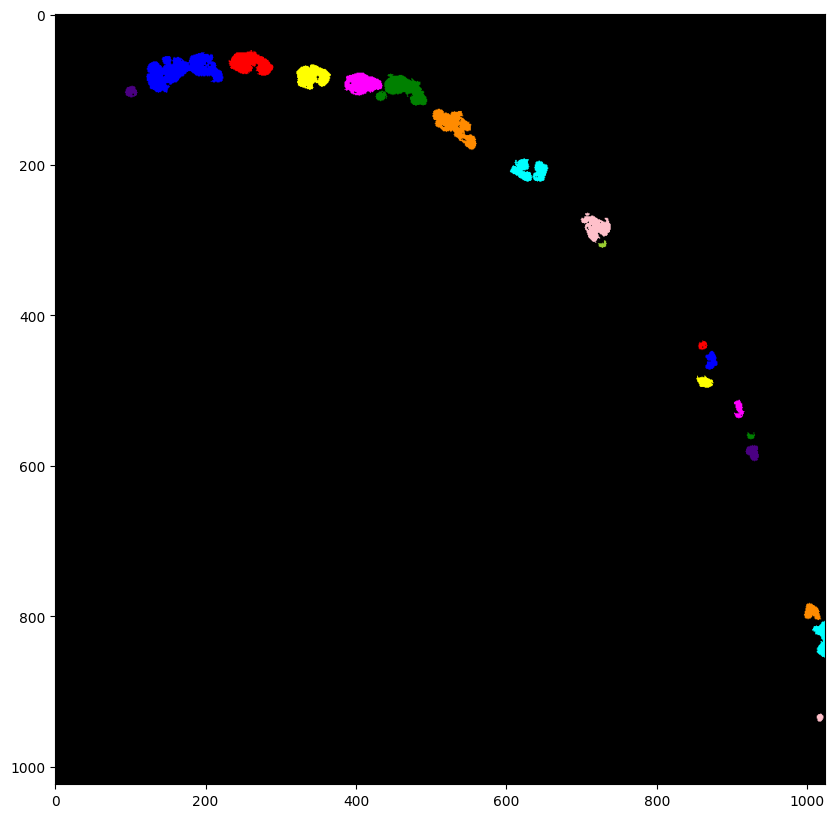

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(maxi)
ax[1].imshow(tissue_troughs>good_crypts, cmap='gray')
ax[2].imshow(
    label2rgb(label(watershed(distance, markers = maxi, mask = tissue_troughs<good_crypts)))
)
fig.show()
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(label2rgb(segmented_crypts))
fig.show()